<a href="https://colab.research.google.com/github/camilothorne/seq2seq-chem/blob/main/NN_layer_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Load dependecies**:

In [1]:
import math, copy, os.path
import torch
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import preprocessing
from matplotlib import pyplot as plt
from torch.nn.modules.module import _addindent

In [2]:
!hostname -I

172.28.0.12 


#### **Custom self attention layer**:

In [3]:
class SelfAttention(torch.nn.Module):
    '''
    Definition of layer is as follows:

        out = softmax( (Q * K^T) / sqrt(d)) * V

    where Q, V and K are linear transforms of the input
    resp. activation of previous layer.

    Derived from https://stackoverflow.com/questions/76648620/how-do-i-implement-this-attention-layer-in-pytorch
    '''
    def __init__(self, input_dim: int) -> None:

        super(SelfAttention, self).__init__()
        self.feature_size = input_dim
        self.query = torch.nn.Linear(input_dim, input_dim)
        self.key = torch.nn.Linear(input_dim, input_dim)
        self.value = torch.nn.Linear(input_dim, input_dim)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        '''
        Init parameters with random weights
        '''
        stdv = 1.0 / math.sqrt(self.feature_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, +stdv)

    def forward(self, input: torch.Tensor, mask=None) -> tuple[torch.Tensor, torch.Tensor]:

        # Apply linear transformations
        keys = self.key(input)
        queries = self.query(input)
        values = self.value(input)
        # Scaled dot-product attention
        scores = torch.matmul(queries.transpose(0,1), keys) / (self.feature_size**0.5)
        # Apply mask (if provided)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        # Apply softmax
        attention_weights = torch.nn.functional.softmax(scores, dim=-1)
        # Multiply weights with values
        out = torch.matmul(values, attention_weights)
        return out, attention_weights

In [4]:
class modSelfAttention(torch.nn.Module):
    '''
    Custom model using custom layer
    '''

    def __init__(self, input_features):

        super(modSelfAttention, self).__init__()
        self.input_features = input_features
        self.state_size = state_size
        self.rnn = SelfAttention(input_features)
        self.output_layer = torch.nn.Linear(input_features, 1)

    def forward(self, input:torch.tensor) -> torch.tensor:

        res, att = self.rnn(input)
        out = self.output_layer(res)
        return out

#### **Custom RNN layer:**

In [5]:
class VanillaRNN(torch.nn.Module):
    """
    Basic RNN block. This represents a single layer of RNN.

    Derived from:
        https://jaketae.github.io/study/pytorch-rnn/
        https://solardevs.com/blog/coding-a-recurrent-neural-network-rnn-from-scratch-using-pytorch/
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:

        """
        input_size: number of features of your input vector
        idden_size: number of hidden neurons
        output_size: number of features of your output vector
        """
        super(VanillaRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.i2h = torch.nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = torch.nn.Linear(hidden_size, hidden_size)
        self.h2o = torch.nn.Linear(hidden_size, output_size)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        '''
        Init parameters with random weights
        '''
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, +stdv)

    def forward(self, x:torch.Tensor, hidden_state:torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns computed output and tanh(i2h + h2h)
        Inputs:
          x: input vector
          hidden_state: previous hidden state
        Outputs:
          out: linear output (without activation because of how PyTorch works)
          hidden_state: new hidden state matrix
        """
        x_res = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = torch.tanh(x_res + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

In [6]:
class modVanillaRNN(torch.nn.Module):
    '''
    Custom model using custom layer.
    '''

    def __init__(self, input_features, state_size, output_features, batch_size):

        super(modVanillaRNN, self).__init__()
        self.state_size = state_size
        self.batch_size = batch_size
        self.rnn = VanillaRNN(input_features, state_size, state_size)
        self.output_layer = torch.nn.Linear(state_size, output_features)

    def init_zero_hidden(self, batch_size=1) -> torch.Tensor:
        """
		Helper function:
          Returns a hidden state with specified batch size, defaults to 1.
          Used only when we train model on sequence/temporal data.
        """
        return torch.zeros(batch_size, self.state_size, requires_grad=False)

    def forward(self, input:torch.tensor) -> torch.tensor:
        '''
        Should we init the hidden state weights at every batch / epoch?
          In general, no: it is updated at every time-step, but we're not considering
          features timesteps, therefore, it is OK here.

          Check again: https://jaketae.github.io/study/pytorch-rnn/
        '''
        h = torch.randn(self.batch_size, self.state_size) # hidden state (random)
        out, hidden = self.rnn(input, h)
        out = self.output_layer(out)
        return out

#### **Vanilla GRU layer:**

In [11]:
class VanillaGRU(torch.nn.Module):
    '''
    Vanilla GRU layer.

    Derived from:
        https://solardevs.com/blog/coding-a-recurrent-neural-network-rnn-from-scratch-using-pytorch/
    '''
    def __init__(self, input_dim:int, hidden_dim:int, bias=True) -> None:

        super(VanillaGRU, self).__init__()
        self.input_size = input_dim
        self.hidden_size = hidden_dim
        self.bias = bias
        self.x2h = torch.nn.Linear(
            input_dim, 3 * hidden_dim, bias=bias
            )
        self.h2h = torch.nn.Linear(
            hidden_dim, 3 * hidden_dim, bias=bias
            )
        self.reset_parameters()

    def reset_parameters(self) -> None:
        '''
        Init parameters with random weights
        '''
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, +stdv)

    def forward(self, input:torch.Tensor, hidden: torch.Tensor) -> torch.Tensor:

        input = input.view(-1, input.size(1))

        gate_x = self.x2h(input)
        gate_h = self.h2h(hidden)

        gate_x = gate_x.squeeze()
        gate_h = gate_h.squeeze()

        i_r, i_i, i_n = gate_x.chunk(3, 1)
        h_r, h_i, h_n = gate_h.chunk(3, 1)

        resetgate = torch.nn.functional.sigmoid(i_r + h_r)
        inputgate = torch.nn.functional.sigmoid(i_i + h_i)
        newgate = torch.nn.functional.tanh(i_n + (resetgate * h_n))

        out = newgate + inputgate * (hidden - newgate)

        return out

In [12]:
class modVanillaGRU(torch.nn.Module):
    '''
    Custom model using custom layer.
    '''

    def __init__(self, input_features, state_size, output_features, batch_size):

        super(modVanillaGRU, self).__init__()
        self.state_size = state_size
        self.batch_size = batch_size
        self.rnn = VanillaGRU(input_features, state_size, state_size)
        self.output_layer = torch.nn.Linear(state_size, output_features)

    def init_zero_hidden(self, batch_size=1) -> torch.Tensor:
        """
		Helper function:
          Returns a hidden state with specified batch size, defaults to 1.
          Used only when we train model on sequence/temporal data.
        """
        return torch.zeros(batch_size, self.state_size, requires_grad=False)

    def forward(self, input:torch.tensor) -> torch.tensor:
        '''
        Should we init the hidden state weights at every batch / epoch?
          In general, no: it is updated at every time-step, but we're not considering
          features timesteps, therefore, it is OK here.
        '''
        h = torch.randn(self.batch_size, self.state_size) # hidden state (random)
        out = self.rnn(input, h)
        out = self.output_layer(out)
        return out

#### **Custom linear layer**:

In [13]:
class VanillaLinear(torch.nn.Module):
    '''
    Definition of layer is as follows:

        out = W^Tx + b
    '''
    def __init__(self, input_dim:int, out_dim:int, bias=True) -> None:

        super(VanillaLinear, self).__init__()
        self.input_dim = input_dim
        self.out_dim = out_dim
        self.weights = torch.nn.Parameter(
            torch.empty(input_dim, out_dim)
        )
        self.bias = torch.nn.Parameter(
            torch.empty(out_dim)
        )
        self.reset_parameters()

    def reset_parameters(self) -> None:
        '''
        Init parameters with random weights
        '''
        stdv = 1.0 / math.sqrt(self.input_dim)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, +stdv)

    def forward(self, input:torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        '''
        Here we compute the tensor multiplication
        Note that x.t() means x^T (transposition)
        '''
        #print('input (layer)', input.shape)
        #print('weights (layer)', self.weights.shape)
        #print('transposed weights', self.weights.t().shape)
        mul = torch.matmul(input, self.weights)     # Wx^T
        out = torch.add(mul, self.bias)             # Wx^T + b
        return out, mul

In [14]:
class modLinear(torch.nn.Module):
    '''
    Custom model using custom layer
    '''
    def __init__(self, input_features:int, state_size:int, output_features:int) -> None:

        super(modLinear, self).__init__()
        self.lnn1    = VanillaLinear(input_dim=input_features, out_dim=state_size)
        self.lnn1_bn = torch.nn.BatchNorm1d(num_features=state_size)
        self.lnn2    = VanillaLinear(input_dim=state_size, out_dim=output_features)
        self.lnn2_bn = torch.nn.BatchNorm1d(num_features=output_features)

    def forward(self, input:torch.tensor) -> torch.tensor:

        #print(input.shape)
        out1, _    = self.lnn1(input)
        #print(out_x.shape)
        out2, _   = self.lnn2(self.lnn1_bn(out1))
        out       = self.lnn2_bn(out2)
        #print(out.shape)
        return out

#### **Train**:

In [15]:
def train_variant(dnn:torch.nn.Module,
                  X_train:np.array,
                  X_test:np.array,
                  y_train:np.array,
                  y_test:np.array,
                  val_history:list,
                  loss_history:list,
                  data_size:int,
                  batch_size:int,
                  clip_value:int,
                  my_lr:float,
                  my_momentum:float,
    ) -> None:

    print("--------------------")
    print("Model and parameters:")
    print(torch_summarize(dnn))

    # Choose optimizer and loss function (MSE)
    optimizer   = torch.optim.SGD(dnn.parameters(), lr=my_lr, momentum=my_momentum)
    mse_loss    = torch.nn.MSELoss()

    # Hold the best model
    best_mse        = np.inf   # init to infinity
    best_weights    = None

    torch.autograd.set_detect_anomaly(True) # check for anomaly in gradients

    print("--------------------")
    print(f"SGD for {epochs} epochs, with batch size {batch_size}:")
    for i in tqdm(range(epochs)):

        dnn.train()
        #print(f"epoch {i}")
        start = 0
        count = 0

        while data_size - start > batch_size:
            #print(f"\nbatch {count}:")
            optimizer.zero_grad()
            #print("forward pass")
            #print(f"model inputs {X_train[start:start+batch_size].shape}")
            out = dnn(X_train[start:start+batch_size]) # forward pass
            loss = mse_loss(out, y_train[start:start+batch_size])
            #print(f"model preds {out.shape} vs gold {y_train[start:start+batch_size].shape} shapes")
            #print(f"loss: {loss.item()}")
            #loss.backward(retain_graph=True, gradient=loss.grad)
            #print("backward pass")
            loss.backward()
            if clip_value > 0:
                torch.nn.utils.clip_grad_norm_(dnn.parameters(), clip_value)
            optimizer.step()
            start = start + batch_size
            count = count + 1
            #if ((i%10 == 0) & (count%20 == 0)):
            #    print(f" - slice (train) {start}--{start+batch_size}")
            #    print(" - loss at epoch {} and train batch {} is: {:.10f}".format(i, count, loss.item()))

        dnn.eval()
        estart = 0
        ecount = 0
        while test_size - estart > batch_size:

            y_pred = dnn(X_test[estart:estart+batch_size])
            mse = mse_loss(y_pred, y_test[estart:estart+batch_size])
            if ((i%10 == 0) & (ecount%20 == 0)):
                loss_history.append(loss.item())
                #print(f" - slice (val) {estart}--{estart+batch_size}")
                #print(" - MSE at epoch {} and test batch {} is: {:.10f}".format(i, ecount, mse.item()))
                val_history.append(mse.item())
                if mse.item() < best_mse:
                    best_mse = mse.item()
                    best_weights = copy.deepcopy(dnn.state_dict())
            estart = estart + batch_size
            ecount = ecount + 1

    #print("--------------------")
    #print("Network gradients:")
    #for name, param in dnn.named_parameters():
    #    print(" - grads: ", name, torch.isfinite(param.grad).all())

    print("--------------------")
    print("MSE (best): %.2f" % best_mse)
    print("RMSE (best): %.2f" % np.sqrt(best_mse))
    print("--------------------")

####  **Visualize:**

In [16]:
def torch_summarize(model:torch.nn.Module,
                    show_weights=True,
                    show_parameters=True) -> str:
    """
    Summarizes torch model by showing trainable parameters and weights
    """
    tmpstr = model.__class__.__name__ + ' (\n'
    for key, module in model._modules.items():
        # if it contains layers let call it recursively to get params and weights
        if type(module) in [
            torch.nn.modules.container.Container,
            torch.nn.modules.container.Sequential
        ]:
            modstr = torch_summarize(module)
        else:
            modstr = module.__repr__()
        modstr = _addindent(modstr, 2)
        params = sum([np.prod(p.size()) for p in module.parameters()])
        weights = tuple([tuple(p.size()) for p in module.parameters()])
        tmpstr += '  (' + key + '): ' + modstr
        if show_weights:
            tmpstr += ', weights={}'.format(weights)
        if show_parameters:
            tmpstr +=  ', parameters={}'.format(params)
        tmpstr += '\n'
    tmpstr = tmpstr + ')'
    return tmpstr

In [17]:
def plot_result(loss_history:list,
                val_history:list) -> None:
  '''
  Display learning curve
  '''
  %matplotlib inline
  plt.plot(loss_history, label="train")
  plt.plot(val_history, label="val")
  plt.ylabel("MSE loss")
  plt.xlabel("Validation batch")
  plt.xticks(range(0,len(val_history)))
  plt.title(f"Training loss over {epochs} epochs")
  plt.legend(loc='upper right')

#### **Data and (shared) hyper-params**:

Only the clipping value changes per experiment.

In [18]:
!ls sample_data/

anscombe.json		     california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv		   README.md


In [19]:
'''
Needs to be imported only once!
'''
#from sklearn.datasets import fetch_california_housing

'\nNeeds to be imported only once!\n'

In [20]:
'''
We test the code on the California housing Scikit-learn dataset
'''
# Read and scale data
calif_tr     = pd.read_csv('sample_data/california_housing_train.csv')
calif_te     = pd.read_csv('sample_data/california_housing_test.csv')
calif        = pd.concat([calif_tr, calif_te],ignore_index=True)

print(calif.head())
print(calif.shape)

# Scale data
scaler  = preprocessing.MinMaxScaler()
X       = scaler.fit_transform(calif.values[:,0:7].astype(np.float32))
y       = calif.values[:,8].astype(np.float32)

print(X)
print(y)

# train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train).reshape(-1, 1)
X_test  = torch.tensor(X_test)
y_test  = torch.tensor(y_test).reshape(-1, 1)

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -114.31     34.19                15.0       5612.0          1283.0   
1    -114.47     34.40                19.0       7650.0          1901.0   
2    -114.56     33.69                17.0        720.0           174.0   
3    -114.57     33.64                14.0       1501.0           337.0   
4    -114.57     33.57                20.0       1454.0           326.0   

   population  households  median_income  median_house_value  
0      1015.0       472.0         1.4936             66900.0  
1      1129.0       463.0         1.8200             80100.0  
2       333.0       117.0         1.6509             85700.0  
3       515.0       226.0         3.1917             73400.0  
4       624.0       262.0         1.9250             65500.0  
(20000, 9)
[[1.         0.17534518 0.27450982 ... 0.19894476 0.02836402 0.07745437]
 [0.98406315 0.19766212 0.3529412  ... 0.29484794 0.03155918 0.07597435]
 [0.97509956 0

In [21]:
# Hyperparams

state_size      = 32
epochs          = 100
batch_size      = 128
my_lr           = 0.001
my_momentum     = 0.009
out_features    = y_train.shape[1]
input_features  = X_train.shape[1]
data_size       = X_train.shape[0]
test_size       = X_test.shape[0]

#### **Exp1) Experiment with RNN:**

In [22]:
# Monitor training
loss_history    = []
val_history     = []

# Instantiate model
model = modVanillaRNN(input_features, state_size, out_features, batch_size)

# Train
train_variant(model,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              val_history=val_history,
              loss_history=loss_history,
              data_size=data_size,
              batch_size=batch_size,
              clip_value=100,
              my_lr=my_lr,
              my_momentum=my_momentum
)

--------------------
Model and parameters:
modVanillaRNN (
  (rnn): VanillaRNN(
    (i2h): Linear(in_features=7, out_features=32, bias=False)
    (h2h): Linear(in_features=32, out_features=32, bias=True)
    (h2o): Linear(in_features=32, out_features=32, bias=True)
  ), weights=((32, 7), (32, 32), (32,), (32, 32), (32,)), parameters=2336
  (output_layer): Linear(in_features=32, out_features=1, bias=True), weights=((1, 32), (1,)), parameters=33
)
--------------------
SGD for 100 epochs, with batch size 128:


  0%|          | 0/100 [00:00<?, ?it/s]

--------------------
MSE (best): 12821647360.00
RMSE (best): 113232.71
--------------------


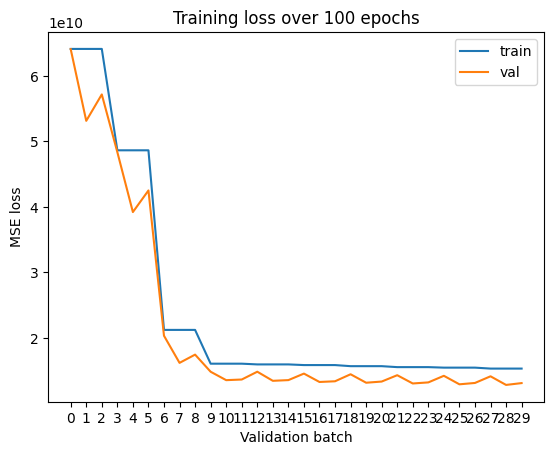

In [23]:
# Plot learning curve
plot_result(loss_history, val_history)

#### **Exp2) Experiment with attention:**

In [24]:
# Monitor training
loss_history    = []
val_history     = []

# Instantiate model
model = modSelfAttention(input_features)

# Train
train_variant(model,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              val_history=val_history,
              loss_history=loss_history,
              data_size=data_size,
              batch_size=batch_size,
              clip_value=100,
              my_lr=my_lr,
              my_momentum=my_momentum
)

--------------------
Model and parameters:
modSelfAttention (
  (rnn): SelfAttention(
    (query): Linear(in_features=7, out_features=7, bias=True)
    (key): Linear(in_features=7, out_features=7, bias=True)
    (value): Linear(in_features=7, out_features=7, bias=True)
  ), weights=((7, 7), (7,), (7, 7), (7,), (7, 7), (7,)), parameters=168
  (output_layer): Linear(in_features=7, out_features=1, bias=True), weights=((1, 7), (1,)), parameters=8
)
--------------------
SGD for 100 epochs, with batch size 128:


  0%|          | 0/100 [00:00<?, ?it/s]

--------------------
MSE (best): 13627731968.00
RMSE (best): 116737.88
--------------------


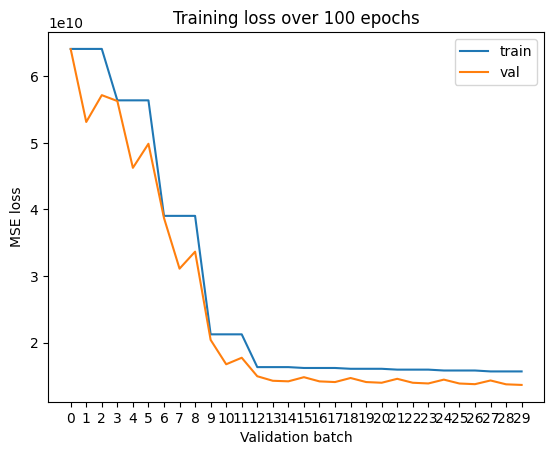

In [25]:
# Plot learning curve
plot_result(loss_history, val_history)

#### **Exp 3) Experiment with custom linear model:**

In [27]:
# Instantiate model
model = modLinear(input_features, state_size, out_features)

In [28]:
# Monitor training
loss_history    = []
val_history     = []

# Train
train_variant(model,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              val_history=val_history,
              loss_history=loss_history,
              data_size=data_size,
              batch_size=batch_size,
              clip_value=0,             # batch normalization and gradient clipping don't seem to intreact very well!
              my_lr=my_lr,
              my_momentum=my_momentum
)

--------------------
Model and parameters:
modLinear (
  (lnn1): VanillaLinear(), weights=((7, 32), (32,)), parameters=256
  (lnn1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), weights=((32,), (32,)), parameters=64
  (lnn2): VanillaLinear(), weights=((32, 1), (1,)), parameters=33
  (lnn2_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), weights=((1,), (1,)), parameters=2
)
--------------------
SGD for 100 epochs, with batch size 128:


  0%|          | 0/100 [00:00<?, ?it/s]

--------------------
MSE (best): 7909536768.00
RMSE (best): 88935.58
--------------------


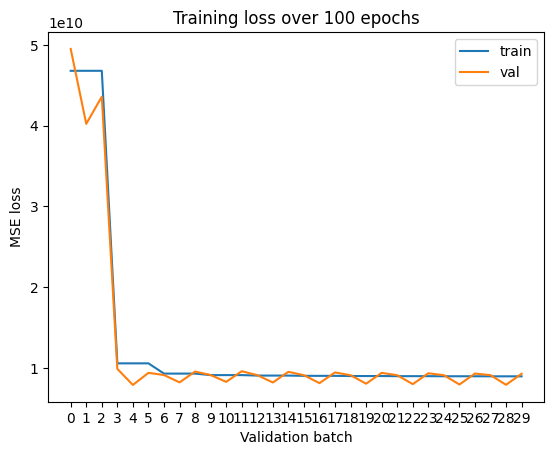

In [29]:
# Plot learning curve
plot_result(loss_history, val_history)

#### **Exp 4) Experiment with GRU:**

In [31]:
# Monitor training
loss_history    = []
val_history     = []

# Instantiate model
model = modVanillaGRU(input_features, state_size, out_features, batch_size)

# Train
train_variant(model,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              val_history=val_history,
              loss_history=loss_history,
              data_size=data_size,
              batch_size=batch_size,
              clip_value=10000,
              my_lr=my_lr,
              my_momentum=my_momentum
)

--------------------
Model and parameters:
modVanillaGRU (
  (rnn): VanillaGRU(
    (x2h): Linear(in_features=7, out_features=96, bias=True)
    (h2h): Linear(in_features=32, out_features=96, bias=True)
  ), weights=((96, 7), (96,), (96, 32), (96,)), parameters=3936
  (output_layer): Linear(in_features=32, out_features=1, bias=True), weights=((1, 32), (1,)), parameters=33
)
--------------------
SGD for 100 epochs, with batch size 128:


  0%|          | 0/100 [00:00<?, ?it/s]

--------------------
MSE (best): 13950534656.00
RMSE (best): 118112.38
--------------------


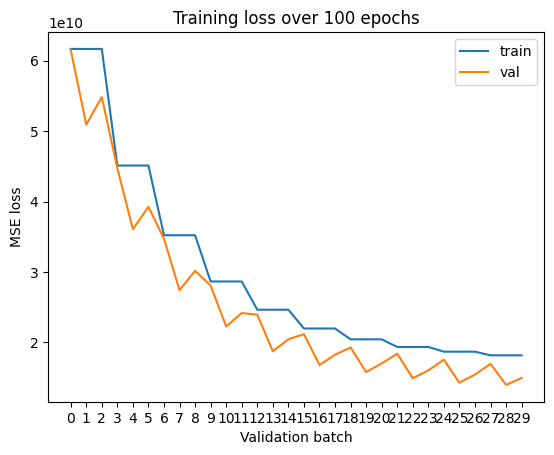

In [32]:
# Plot learning curve
plot_result(loss_history, val_history)